# Create model ready dataset from cisTopic output

In [6]:
import os
import pickle
import numpy as np
import pandas as pd
import pyranges as pr
from pycisTopic.topic_binarization import binarize_topics, smooth_topics_f
from pycisTopic.topic_qc import evaluate_models, compute_topic_metrics

In [107]:
# Define arguments, will be command line
data_dir = "/cellar/users/aklie/data/ml4gland/collabs/er_stress_regulation/test"
dataset_name = "test"
output_dir = "/cellar/users/aklie/data/ml4gland/collabs/er_stress_regulation/test"

In [108]:
# Load cisTopic_obj
def load_cisTopic_obj(file_name):
    """Load a cisTopic object from a pickle file"""
    with open(file_name, "rb") as f:
        cisTopic_obj = pickle.load(f)
    cisTopic_obj.selected_model.topic_ass = {}
    return cisTopic_obj
cistopic_obj = load_cisTopic_obj(os.path.join(data_dir, dataset_name + ".pycisTopic_obj.pkl"))

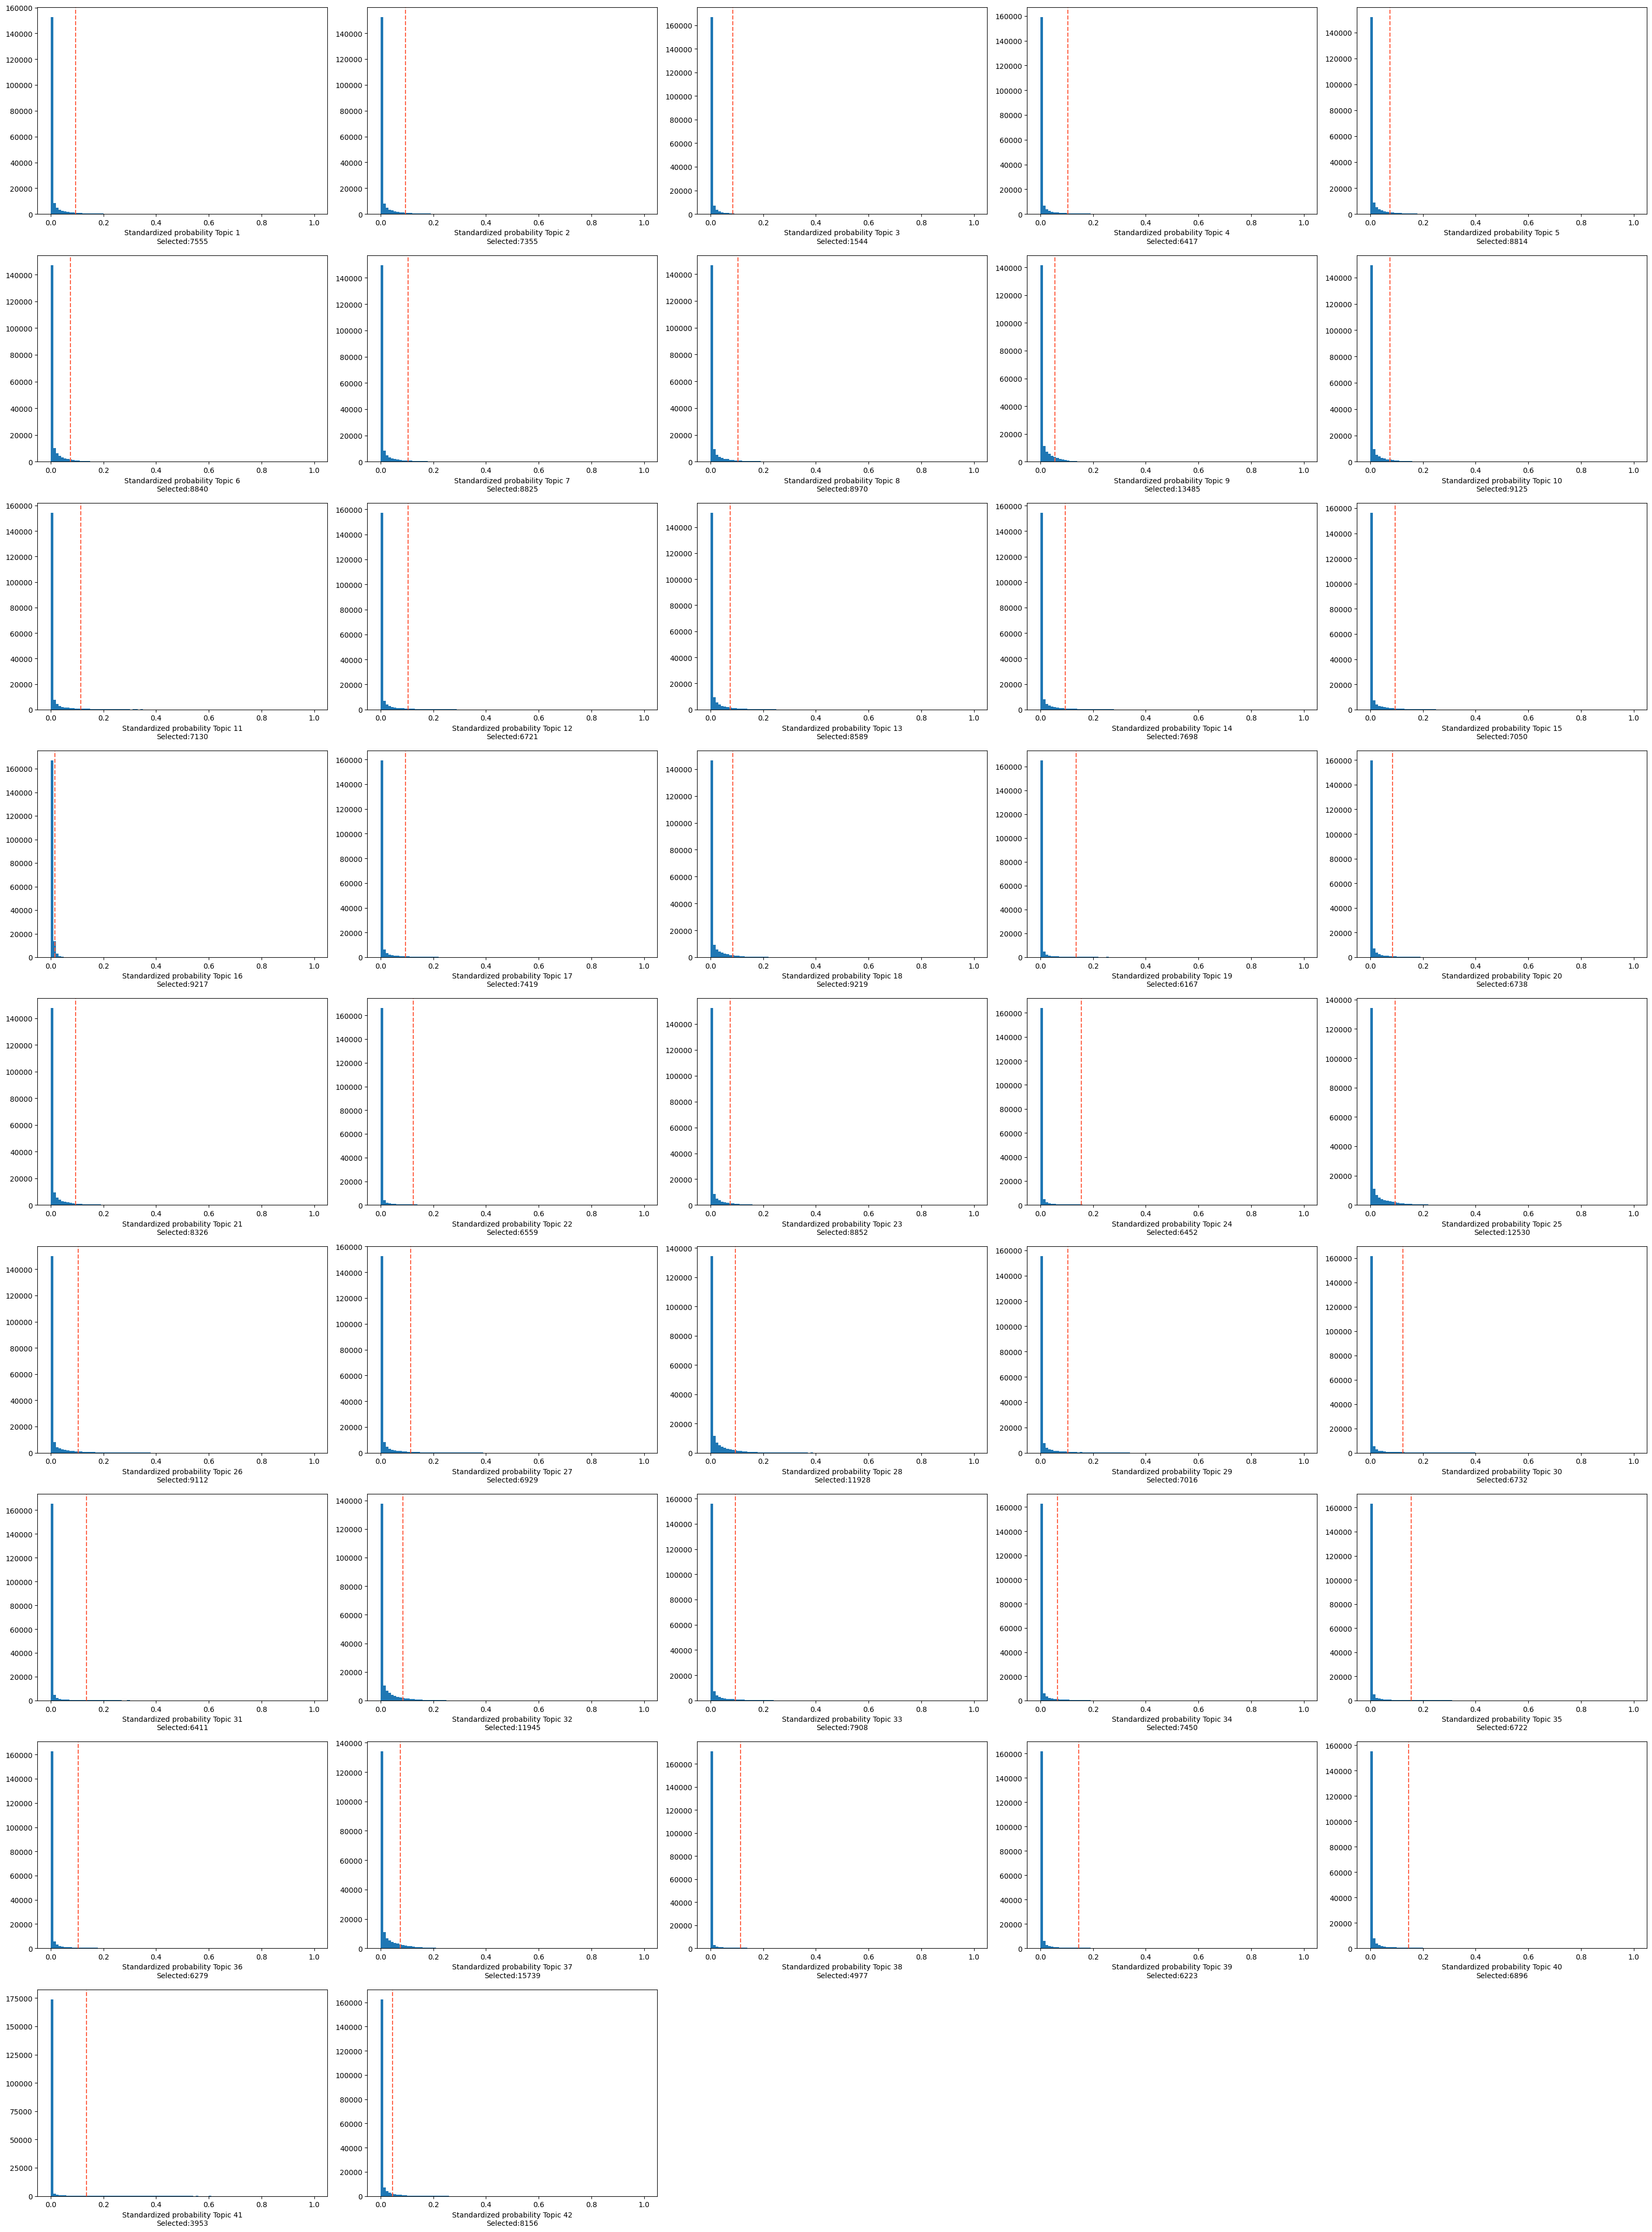

In [124]:
# Binarize topics
region_bin_topics_otsu = binarize_topics(cistopic_obj, method='otsu', plot=True, num_columns=5, save=os.path.join(output_dir, "region_topic_binarization.pdf"))
all_regions = cistopic_obj.selected_model.topic_region.index
all_regions = all_regions[all_regions.str.contains("chr")]

In [125]:
def get_per_regions_topic_membership(region_dict):
    topic_regions_pd = pd.Index([])
    topic_regions_lst = []
    topic_region_mp = {}
    for topic, regions in region_dict.items():
        topic_regions_lst += list(regions.index)
        topic_regions_pd = pd.Index.union(topic_regions_pd, regions.index)
        for region in regions.index:
            topic_region_mp.setdefault(region, []).append(topic)
    return topic_regions_pd, topic_region_mp, topic_regions_lst
topic_regions_pd, topic_region_mp, topic_regions_lst = get_per_regions_topic_membership(region_bin_topics_otsu)

In [127]:
def get_nontopic_regions(all_regions, topic_regions_pd):
    non_topic_regions = all_regions[~all_regions.isin(topic_regions_pd)]
    return non_topic_regions
non_topic_regions = get_nontopic_regions(all_regions, topic_regions_pd)

In [138]:
def create_binarized_matrix(all_regions, topic_region_mp, n_topics):
    arr = np.zeros((len(all_regions), n_topics))
    for i, row in enumerate(all_regions):
        if row in topic_region_mp:
            topic_nums = []
            for topic in topic_region_mp[row]:
                topic_nums.append(int(topic.split("Topic")[-1])-1)
            arr[i, topic_nums] = 1
    return arr
arr = create_binarized_matrix(all_regions, topic_region_mp, 42)
arr.shape

(185580, 42)

In [140]:
def check_topic_binarization(region_dict, arr, all_regions, non_topic_regions, topic_regions_pd, topic_regions_lst):
    for topic, regions in region_dict.items():
        assert non_topic_regions.isin(regions.index).sum() == 0, f"Topic {topic} contains a non-topic regions"
    assert np.all(np.array([len(regions) for _, regions in region_dict.items()]) == arr.sum(axis=0)), "Number of regions per topic does not match the number of 1s in the matrix"
    assert np.all(all_regions[arr.sum(axis=1) == 0].isin(non_topic_regions)), "Number of regions that are 0 across all topics does not match the number of non-topic regions"
    assert np.all(~all_regions[arr.sum(axis=1) == 0].isin(topic_regions_pd)), "Number of regions that are not 0 across all topics does not match the number of topic regions"
    assert arr.sum() == len(topic_regions_lst), "Number of 1s in the matrix does not match the number of topic regions"
check_topic_binarization(region_bin_topics_otsu, arr, all_regions, non_topic_regions, topic_regions_pd, topic_regions_lst)

In [153]:
def save_seqdata_files(
    bin_mtx, 
    regions, 
    output_dir, 
    dataset_name
):
    region_split = [region.split("-") for region in regions.str.replace(":", "-")]
    region_df = pd.DataFrame(region_split, columns=["Chromosome", "Start", "End"])
    pr_obj = pr.PyRanges(region_df)
    seqs = pr.get_fasta(pr_obj, "/cellar/users/aklie/data/ml4gland/genomes/hg38/hg38.fa")
    np.save(os.path.join(output_dir, dataset_name + "_labels.npy"), bin_mtx)
    np.save(os.path.join(output_dir, dataset_name + "_regions.npy"), regions)
    np.save(os.path.join(output_dir, dataset_name + "_seqs.npy"), seqs)
save_seqdata_files(arr, all_regions, output_dir, dataset_name)

## Script

In [155]:
%%bash
source activate scenicplus
script=/cellar/users/aklie/projects/ML4GLand/collabs/er_stress_regulation/scripts/pycisTopic2Seqs.py
dataset_dir=/cellar/users/aklie/data/ml4gland/collabs/er_stress_regulation/test
dataset_name=test
output_dir=/cellar/users/aklie/data/ml4gland/collabs/er_stress_regulation/test
cmd="python $script \
    --dataset_dir $dataset_dir \
    --dataset_name $dataset_name \
    --output_dir $output_dir"
eval $cmd

Loading cisTopic object
Binarizing topics
Figure(3200x4320)
Creating binarized matrix
Checking binarized matrix
Saving output files


# Scratch

In [ ]:
data_dir = "/cellar/users/aklie/data/ml4gland/collabs/er_stress_regulation/beta_cells_all_peaks"
dataset_name = "beta_cells_all_peaks"
output_dir = "/cellar/users/aklie/data/ml4gland/collabs/er_stress_regulation/beta_cells_all_peaks"

In [ ]:
## Load the pickle object
cistopic_obj = pickle.load(open(os.path.join(data_dir, dataset_name + ".pycisTopic_obj.pkl"), "rb"))
cistopic_obj.selected_model.topic_ass = {}

In [ ]:
region_data = cistopic_obj.region_data
region_data_filt = region_data[region_data.index.str.contains("chr")]

In [ ]:
# Get 97.5% quantile for each colum in the region topic membership matrix
#region_topic_membership = smooth_topics_f(cistopic_obj.selected_model.topic_region)
#region_topic_membership = region_topic_membership.apply(lambda x: (x - np.min(x)) / np.ptp(x))
#binarization_quantile = region_topic_membership.quantile(.975).to_dict()
#binarize_topics(cistopic_obj, predefined_thr=binarization_quantile, plot=True, num_columns=5)

In [ ]:
topic_regions_pd = pd.Index([])
topic_regions_lst = []
topic_region_mp = {}
for topic, regions in region_bin_topics_otsu.items():
    topic_regions_lst += list(regions.index)
    topic_regions_pd = pd.Index.union(topic_regions_pd, regions.index)
    for region in regions.index:
        topic_region_mp.setdefault(region, []).append(topic)
topic_regions_np = np.array(topic_regions_lst)
topic_regions_set = set(topic_regions_lst)

In [ ]:
arr.sum(axis=0)

array([ 7555.,  7355.,  1544.,  6417.,  8814.,  8840.,  8825.,  8970.,
       13485.,  9125.,  7130.,  6721.,  8589.,  7698.,  7050.,  9217.,
        7419.,  9219.,  6167.,  6738.,  8326.,  6559.,  8852.,  6452.,
       12530.,  9112.,  6929., 11928.,  7016.,  6732.,  6411., 11945.,
        7908.,  7450.,  6722.,  6279., 15739.,  4977.,  6223.,  6896.,
        3953.,  8156.])

In [ ]:
np.array([len(regions) for topic, regions in region_bin_topics_otsu.items()]) == arr.sum(axis=0)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [ ]:
np.all(all_regions[arr.sum(axis=1) == 0].isin(non_topic_regions))

True

In [ ]:
np.all(~all_regions[arr.sum(axis=1) == 0].isin(topic_regions_pd))

True

In [ ]:
arr.sum() == len(topic_regions_lst)

True